In [1]:
import pandas as pd
import numpy as np

In [2]:
with open("tweets_AAPL.csv",'rb') as dfile:
    dstr = str(dfile.read())[1:5]

Open, High, Low, Close, Adj Close

In [3]:
with open("tweets_AAPL.csv",'rb') as dfile:
    dstr = str(dfile.read())[2:]
darr = dstr.split('\\r')
dmat = [rs.split(",") for rs in darr]
dmat = [r[:1] + [",".join(r[1:-5])] + r[-5:] for r in dmat]
dmat = [r for r in dmat if len(r) == 7]
df = pd.DataFrame(dmat)

In [4]:
df.columns = ["date","twt","open","high","low","close","adjclose"]

In [5]:
%time df["twt"] = df["twt"].apply(lambda text: text.lower().split())

CPU times: user 1.55 s, sys: 270 ms, total: 1.82 s
Wall time: 2.41 s


In [6]:
# TODO : sort dates proper
# %time df["date"] = df["date"].apply(lambda date: )

In [7]:
price = df[["date","open"]].groupby("date").aggregate(lambda gp: tuple(set(gp))[0])
pval = price.values[1:].astype(float)
up = ((pval[1:] - pval[:-1]) > 0).astype(int)
price["openup"] = [0] + list(up.T[0]) + [0]

In [8]:
%time df["openup"] = df["date"].apply(lambda date: price["openup"].loc[date])

CPU times: user 9.87 s, sys: 114 ms, total: 9.98 s
Wall time: 10.9 s


In [9]:
%time df["twt"] = df["twt"].apply(lambda text: text.lower().split())

AttributeError: 'list' object has no attribute 'lower'

In [10]:
import gensim
%time w2vM = gensim.models.Word2Vec(df["twt"])

CPU times: user 53.9 s, sys: 622 ms, total: 54.5 s
Wall time: 24.3 s


In [11]:
# number of samples to aggregate
Ns = int(1e5)

In [12]:
df.shape

(221345, 8)

In [13]:
Ns = int(1e5)

In [14]:
%%time
# MEAN AGGREGATION
tvecs = np.array([np.array([w2vM[t] if t in w2vM
                                else np.zeros((100,))
                            for t in twt]).mean(axis=0)
                 for twt in df["twt"][:Ns]])
# tvecs = np.array([np.array([w2vM[t]
#                             for t in twt
#                             if t in w2vM]).mean(axis=0)
#                  for twt in df["twt"][:Ns]])
# SUM AGGREGATION
# tvecs = np.array([np.array([w2vM[t] if t in w2vM
#                                 else np.zeros((100,))
#                             for t in twt]).sum(axis=0)
#                  for twt in sentDf["SentimentText"][:Ns]])

CPU times: user 12 s, sys: 637 ms, total: 12.7 s
Wall time: 15.5 s


In [20]:
%time df["vecs"] = df["twt"].apply(\
    lambda twt: np.array([w2vM[t] \
                         if t in w2vM else np.zeros((100,)) \
                         for t in twt]).mean(axis=0))

CPU times: user 25.2 s, sys: 968 ms, total: 26.2 s
Wall time: 29 s


/Users/aduriseti/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':


In [116]:
avgvecs = df[["date","vecs"]].groupby("date").sum()
avgvecs["len"] = (df[["date","vecs"]].groupby("date").size())
avgvecs["avgvec"] = avgvecs["vecs"]/avgvecs["len"]
avgvecs = avgvecs.join(price)

CPU times: user 949 ms, sys: 46.3 ms, total: 996 ms
Wall time: 1.27 s


In [84]:
import sklearn
from sklearn import ensemble,svm,neural_network,discriminant_analysis
from sklearn.metrics import roc_curve,auc,precision_recall_curve

from matplotlib import pyplot as plt
% matplotlib inline

def roc_auc(clf,X,y):
    probs = clf.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_str = 'ROC (AUC Gain = %0.2f)' % (roc_auc - 0.5)
    plt.plot(fpr, tpr, lw=1,label=roc_str)
    plt.plot([0,1],[0,1],label="RAN CLF")
    plt.title(roc_str)
    plt.show()

def prrc_auc(clf,X,y):
    probs = clf.predict_proba(X)
    pr, rc, thresholds = precision_recall_curve(y, probs[:, 1])
    roc_auc = auc(rc, pr)
    roc_str = 'Prec vs Recall (AUC Gain = %0.2f)' % (roc_auc - np.mean(y))
    plt.plot(rc,pr, lw=1,label=roc_str)
    plt.plot([0,1],[np.mean(y),np.mean(y)],label="RAN CLF")
    plt.axis([0,1,0,1])
    plt.title(roc_str)
    plt.show()

def evaluate(clf,X,y):
    yhat = clf.predict(X)
    accu = np.mean(yhat == y)
    prec = np.mean(y[yhat == 1])
    recl = np.mean(yhat[y == 1])
    f1 = 2 * prec * recl / (prec + recl)
    print("Accuracy",accu,"Precision",prec,"Recall",recl,"F1",f1)

# Average of tweets in a day

In [122]:
dvecs = np.array([vec.T for vec in avgvecs["vecs"].values])
X = dvecs
y = sumvecs["openup"].values
# inverse classifier
# y = 1 - y

In [124]:
# generate test/train split
ratio = 0.8
tidx = np.random.rand(X.shape[0]) < ratio
pidx = ~tidx

CPU times: user 38.3 ms, sys: 4.79 ms, total: 43.1 ms
Wall time: 49.6 ms
TEST
Accuracy 0.688888888889 Precision 0.75 Recall 0.692307692308 F1 0.72
CPU times: user 7.58 ms, sys: 2.46 ms, total: 10 ms
Wall time: 17.8 ms
TRAIN
Accuracy 0.937823834197 Precision 0.942857142857 Recall 0.942857142857 F1 0.942857142857
CPU times: user 4.98 ms, sys: 1.27 ms, total: 6.25 ms
Wall time: 9.82 ms
ROC AUC


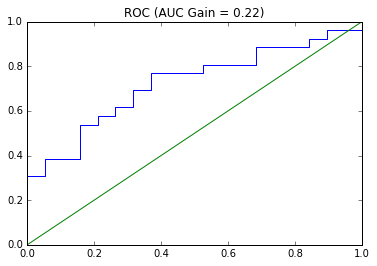

CPU times: user 235 ms, sys: 31.2 ms, total: 266 ms
Wall time: 342 ms
PRECISION/RECALL AUC


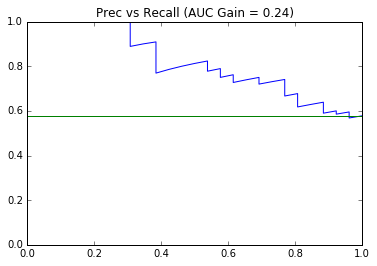

CPU times: user 255 ms, sys: 15.5 ms, total: 271 ms
Wall time: 496 ms


In [126]:
rf = sklearn.ensemble.RandomForestClassifier()
rf.max_depth = 5
clf = rf
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 15.3 ms, sys: 7.37 ms, total: 22.6 ms
Wall time: 21.1 ms
TEST
Accuracy 0.533333333333 Precision 0.631578947368 Recall 0.461538461538 F1 0.533333333333
CPU times: user 2.05 ms, sys: 622 µs, total: 2.67 ms
Wall time: 2.37 ms
TRAIN
Accuracy 0.538860103627 Precision 0.578431372549 Recall 0.561904761905 F1 0.570048309179
CPU times: user 2.07 ms, sys: 782 µs, total: 2.85 ms
Wall time: 2.06 ms
ROC AUC


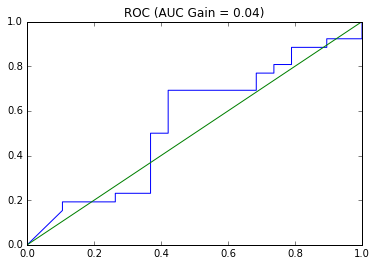

CPU times: user 260 ms, sys: 11.6 ms, total: 272 ms
Wall time: 387 ms
PRECISION/RECALL AUC


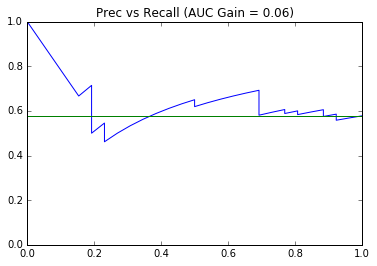

CPU times: user 285 ms, sys: 12.4 ms, total: 297 ms
Wall time: 532 ms


In [127]:
mlp = sklearn.neural_network.MLPClassifier()
clf = mlp
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

/Users/aduriseti/anaconda/lib/python3.5/site-packages/sklearn/discriminant_analysis.py:682: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


CPU times: user 11 ms, sys: 5.52 ms, total: 16.5 ms
Wall time: 16.2 ms
TEST
Accuracy 0.577777777778 Precision 0.577777777778 Recall 1.0 F1 0.732394366197
CPU times: user 1.91 ms, sys: 642 µs, total: 2.55 ms
Wall time: 2.08 ms
TRAIN
Accuracy 1.0 Precision 1.0 Recall 1.0 F1 1.0
CPU times: user 3.13 ms, sys: 1.05 ms, total: 4.18 ms
Wall time: 2.64 ms
ROC AUC


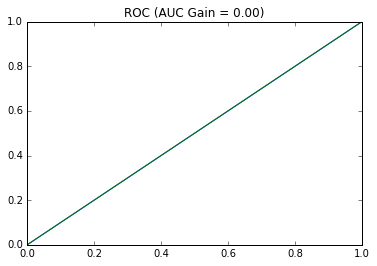

CPU times: user 248 ms, sys: 11.8 ms, total: 260 ms
Wall time: 264 ms
PRECISION/RECALL AUC


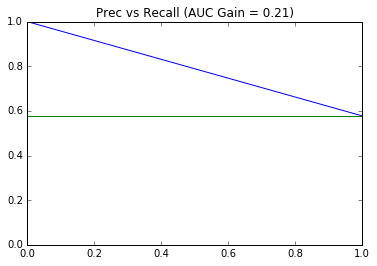

CPU times: user 309 ms, sys: 16 ms, total: 325 ms
Wall time: 583 ms


In [128]:
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
clf = qda
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

# Single tweets

In [82]:
# number of samples to train on
N = int(1e5)
X = tvecs[:N]
y = df["openup"][:N].values
# inverse classifier
# y = 1 - y

In [83]:
# generate test/train split
ratio = 0.8
tidx = np.random.rand(N) < ratio
pidx = ~tidx

CPU times: user 5.96 s, sys: 244 ms, total: 6.2 s
Wall time: 7.79 s
TEST
Accuracy 0.620232838218 Precision 0.613176914214 Recall 0.984693019344 F1 0.755744900594
CPU times: user 41.9 ms, sys: 18 ms, total: 59.8 ms
Wall time: 69.5 ms
TRAIN
Accuracy 0.611174942552 Precision 0.601893386188 Recall 0.987083529361 F1 0.74780072904
CPU times: user 127 ms, sys: 30.4 ms, total: 157 ms
Wall time: 178 ms
ROC AUC


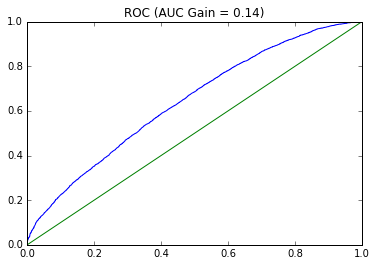

CPU times: user 339 ms, sys: 23 ms, total: 362 ms
Wall time: 569 ms
PRECISION/RECALL AUC


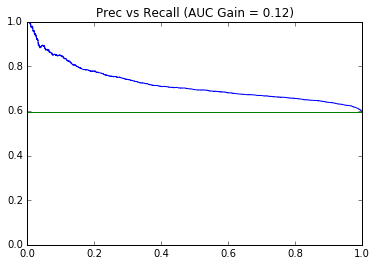

CPU times: user 305 ms, sys: 19 ms, total: 324 ms
Wall time: 449 ms


In [88]:
rf = sklearn.ensemble.RandomForestClassifier()
rf.max_depth = 5
clf = rf
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 1min 15s, sys: 6.39 s, total: 1min 21s
Wall time: 1min 23s
TEST
Accuracy 0.728271778402 Precision 0.757250695272 Recall 0.801513877208 F1 0.778753830439
CPU times: user 74.1 ms, sys: 48.7 ms, total: 123 ms
Wall time: 172 ms
TRAIN
Accuracy 0.792611649515 Precision 0.800274823754 Recall 0.859351610282 F1 0.828761755486
CPU times: user 263 ms, sys: 133 ms, total: 396 ms
Wall time: 483 ms
ROC AUC


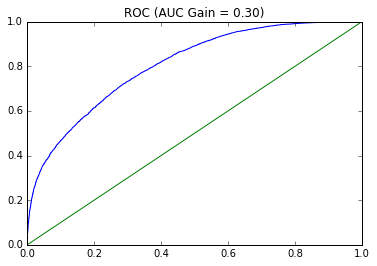

CPU times: user 400 ms, sys: 66.7 ms, total: 467 ms
Wall time: 863 ms
PRECISION/RECALL AUC


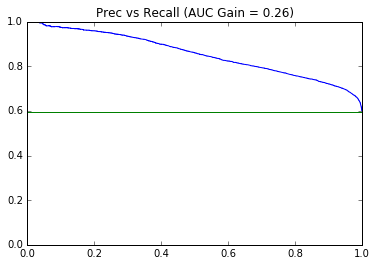

CPU times: user 319 ms, sys: 36.3 ms, total: 356 ms
Wall time: 455 ms


In [89]:
mlp = sklearn.neural_network.MLPClassifier()
clf = mlp
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 2.56 s, sys: 274 ms, total: 2.84 s
Wall time: 2.61 s
TEST
Accuracy 0.638799678844 Precision 0.721195549689 Recall 0.643313708999 F1 0.68003200569
CPU times: user 115 ms, sys: 81.9 ms, total: 197 ms
Wall time: 149 ms
TRAIN
Accuracy 0.647779498451 Precision 0.718079481093 Recall 0.653415166161 F1 0.684222901481
CPU times: user 441 ms, sys: 235 ms, total: 676 ms
Wall time: 505 ms
ROC AUC


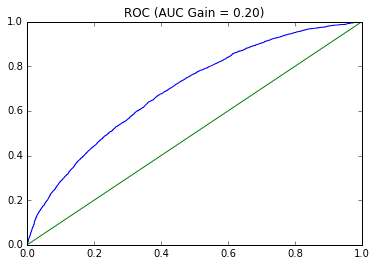

CPU times: user 356 ms, sys: 105 ms, total: 461 ms
Wall time: 462 ms
PRECISION/RECALL AUC


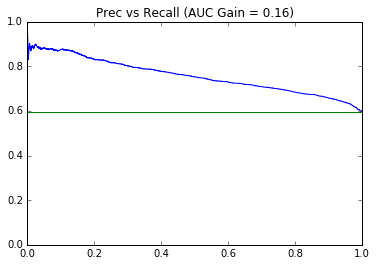

CPU times: user 347 ms, sys: 64 ms, total: 411 ms
Wall time: 411 ms


In [91]:
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
clf = qda
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])